In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

In [ ]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)


2.7.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, matthews_corrcoef,precision_score,average_precision_score,recall_score,f1_score,roc_auc_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC 

In [ ]:
glove_filename='glove.6B.100d.txt'
glove_path='/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt'

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

(400000, 100)

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [ ]:
df1 = pd.read_csv("/content/hateval2019_en_train.csv")
df2= pd.read_csv("/content/hateval2019_en_test.csv")
full_df= df1.append(df2,ignore_index=True)
# df = full_df[["text"]]
full_df["text"] = full_df["text"].astype(str)
full_df.head()

,id,text,HS,TR,AG
0,201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0
1,202,Why would young fighting age men be the vast m...,1,0,0
2,203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0
3,204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0
4,205,Orban in Brussels: European leaders are ignori...,0,0,0


In [ ]:
df= full_df.sample(frac=1.0)
df= df.reset_index(drop=True)

In [ ]:
df.drop('id',axis=1,inplace=True)
df.shape

(12000, 4)

REMOVE USERNAME

In [ ]:
import re

def remove_usernames_links(tweet):
    tweet = re.sub(r'@[^\s]+','',tweet)
    tweet = re.sub(r'http[^\s]+','',tweet)
    return tweet

df['tweet'] = df["text"].apply(remove_usernames_links)
df.head()

,text,HS,TR,AG,tweet
0,"Definitely not! I have the same thought, kind ...",0,0,0,"Definitely not! I have the same thought, kind ..."
1,Of course the Toronto attack is a cover up! Go...,1,0,1,Of course the Toronto attack is a cover up! Go...
2,When your friend owes you money and they're ta...,0,0,0,When your friend owes you money and they're ta...
3,Maybe diversity.Or results of western globaliz...,0,0,0,Maybe diversity.Or results of western globaliz...
4,#50CentFrostyFilms Look At My Half Dollar PopS...,0,0,0,#50CentFrostyFilms Look At My Half Dollar PopS...


LOWER CASING

In [ ]:
df["text_lower"] = df["tweet"].str.lower()
df.head()

,text,HS,TR,AG,tweet,text_lower
0,"Definitely not! I have the same thought, kind ...",0,0,0,"Definitely not! I have the same thought, kind ...","definitely not! i have the same thought, kind ..."
1,Of course the Toronto attack is a cover up! Go...,1,0,1,Of course the Toronto attack is a cover up! Go...,of course the toronto attack is a cover up! go...
2,When your friend owes you money and they're ta...,0,0,0,When your friend owes you money and they're ta...,when your friend owes you money and they're ta...
3,Maybe diversity.Or results of western globaliz...,0,0,0,Maybe diversity.Or results of western globaliz...,maybe diversity.or results of western globaliz...
4,#50CentFrostyFilms Look At My Half Dollar PopS...,0,0,0,#50CentFrostyFilms Look At My Half Dollar PopS...,#50centfrostyfilms look at my half dollar pops...


REMOVE PUNCTUATIONS

In [ ]:
# drop the new column created in last cell
#df.drop(["text_lower"], axis=1, inplace=True)

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df['text_lower'].apply(lambda text: remove_punctuation(text))
df.head()

,text,HS,TR,AG,tweet,text_lower,text_wo_punct
0,"Definitely not! I have the same thought, kind ...",0,0,0,"Definitely not! I have the same thought, kind ...","definitely not! i have the same thought, kind ...",definitely not i have the same thought kind of...
1,Of course the Toronto attack is a cover up! Go...,1,0,1,Of course the Toronto attack is a cover up! Go...,of course the toronto attack is a cover up! go...,of course the toronto attack is a cover up god...
2,When your friend owes you money and they're ta...,0,0,0,When your friend owes you money and they're ta...,when your friend owes you money and they're ta...,when your friend owes you money and theyre tak...
3,Maybe diversity.Or results of western globaliz...,0,0,0,Maybe diversity.Or results of western globaliz...,maybe diversity.or results of western globaliz...,maybe diversityor results of western globaliza...
4,#50CentFrostyFilms Look At My Half Dollar PopS...,0,0,0,#50CentFrostyFilms Look At My Half Dollar PopS...,#50centfrostyfilms look at my half dollar pops...,50centfrostyfilms look at my half dollar popsi...


STOPWORDS

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df.head()

,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop
0,"Definitely not! I have the same thought, kind ...",0,0,0,"Definitely not! I have the same thought, kind ...","definitely not! i have the same thought, kind ...",definitely not i have the same thought kind of...,definitely thought kind 😁 hope hes massive str...
1,Of course the Toronto attack is a cover up! Go...,1,0,1,Of course the Toronto attack is a cover up! Go...,of course the toronto attack is a cover up! go...,of course the toronto attack is a cover up god...,course toronto attack cover god forbid public ...
2,When your friend owes you money and they're ta...,0,0,0,When your friend owes you money and they're ta...,when your friend owes you money and they're ta...,when your friend owes you money and theyre tak...,friend owes money theyre taking little long pa...
3,Maybe diversity.Or results of western globaliz...,0,0,0,Maybe diversity.Or results of western globaliz...,maybe diversity.or results of western globaliz...,maybe diversityor results of western globaliza...,maybe diversityor results western globalizatio...
4,#50CentFrostyFilms Look At My Half Dollar PopS...,0,0,0,#50CentFrostyFilms Look At My Half Dollar PopS...,#50centfrostyfilms look at my half dollar pops...,50centfrostyfilms look at my half dollar popsi...,50centfrostyfilms look half dollar popsicle bi...


REMOVE URLS

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:
df["text_wo_urlno"] = df["text_wo_stop"].apply(lambda text: remove_urls(text))
df.head()

,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop,text_wo_urlno
0,"Definitely not! I have the same thought, kind ...",0,0,0,"Definitely not! I have the same thought, kind ...","definitely not! i have the same thought, kind ...",definitely not i have the same thought kind of...,definitely thought kind 😁 hope hes massive str...,definitely thought kind 😁 hope hes massive str...
1,Of course the Toronto attack is a cover up! Go...,1,0,1,Of course the Toronto attack is a cover up! Go...,of course the toronto attack is a cover up! go...,of course the toronto attack is a cover up god...,course toronto attack cover god forbid public ...,course toronto attack cover god forbid public ...
2,When your friend owes you money and they're ta...,0,0,0,When your friend owes you money and they're ta...,when your friend owes you money and they're ta...,when your friend owes you money and theyre tak...,friend owes money theyre taking little long pa...,friend owes money theyre taking little long pa...
3,Maybe diversity.Or results of western globaliz...,0,0,0,Maybe diversity.Or results of western globaliz...,maybe diversity.or results of western globaliz...,maybe diversityor results of western globaliza...,maybe diversityor results western globalizatio...,maybe diversityor results western globalizatio...
4,#50CentFrostyFilms Look At My Half Dollar PopS...,0,0,0,#50CentFrostyFilms Look At My Half Dollar PopS...,#50centfrostyfilms look at my half dollar pops...,50centfrostyfilms look at my half dollar popsi...,50centfrostyfilms look half dollar popsicle bi...,50centfrostyfilms look half dollar popsicle bi...


REMOVE HTML TAGS

In [ ]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

df["text_wo_htmlno"] = df["text_wo_urlno"].apply(lambda text: remove_html(text))
df.head()


,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop,text_wo_urlno,text_wo_htmlno
0,"Definitely not! I have the same thought, kind ...",0,0,0,"Definitely not! I have the same thought, kind ...","definitely not! i have the same thought, kind ...",definitely not i have the same thought kind of...,definitely thought kind 😁 hope hes massive str...,definitely thought kind 😁 hope hes massive str...,definitely thought kind 😁 hope hes massive str...
1,Of course the Toronto attack is a cover up! Go...,1,0,1,Of course the Toronto attack is a cover up! Go...,of course the toronto attack is a cover up! go...,of course the toronto attack is a cover up god...,course toronto attack cover god forbid public ...,course toronto attack cover god forbid public ...,course toronto attack cover god forbid public ...
2,When your friend owes you money and they're ta...,0,0,0,When your friend owes you money and they're ta...,when your friend owes you money and they're ta...,when your friend owes you money and theyre tak...,friend owes money theyre taking little long pa...,friend owes money theyre taking little long pa...,friend owes money theyre taking little long pa...
3,Maybe diversity.Or results of western globaliz...,0,0,0,Maybe diversity.Or results of western globaliz...,maybe diversity.or results of western globaliz...,maybe diversityor results of western globaliza...,maybe diversityor results western globalizatio...,maybe diversityor results western globalizatio...,maybe diversityor results western globalizatio...
4,#50CentFrostyFilms Look At My Half Dollar PopS...,0,0,0,#50CentFrostyFilms Look At My Half Dollar PopS...,#50centfrostyfilms look at my half dollar pops...,50centfrostyfilms look at my half dollar popsi...,50centfrostyfilms look half dollar popsicle bi...,50centfrostyfilms look half dollar popsicle bi...,50centfrostyfilms look half dollar popsicle bi...


REMOVE DIGITS

In [ ]:
#df['text_wo_digitno'] = df['text_wo_urlno'].apply(lambda x: re.sub('W*dw*','',x))
#df.head()

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

LEMMATIZATION

In [ ]:
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_htmlno"].apply(lambda text: lemmatize_words(text))
df.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop,text_wo_urlno,text_wo_htmlno,text_lemmatized
0,"Definitely not! I have the same thought, kind ...",0,0,0,"Definitely not! I have the same thought, kind ...","definitely not! i have the same thought, kind ...",definitely not i have the same thought kind of...,definitely thought kind 😁 hope hes massive str...,definitely thought kind 😁 hope hes massive str...,definitely thought kind 😁 hope hes massive str...,definitely think kind 😁 hope he massive stroke...
1,Of course the Toronto attack is a cover up! Go...,1,0,1,Of course the Toronto attack is a cover up! Go...,of course the toronto attack is a cover up! go...,of course the toronto attack is a cover up god...,course toronto attack cover god forbid public ...,course toronto attack cover god forbid public ...,course toronto attack cover god forbid public ...,course toronto attack cover god forbid public ...
2,When your friend owes you money and they're ta...,0,0,0,When your friend owes you money and they're ta...,when your friend owes you money and they're ta...,when your friend owes you money and theyre tak...,friend owes money theyre taking little long pa...,friend owes money theyre taking little long pa...,friend owes money theyre taking little long pa...,friend owe money theyre take little long pay back
3,Maybe diversity.Or results of western globaliz...,0,0,0,Maybe diversity.Or results of western globaliz...,maybe diversity.or results of western globaliz...,maybe diversityor results of western globaliza...,maybe diversityor results western globalizatio...,maybe diversityor results western globalizatio...,maybe diversityor results western globalizatio...,maybe diversityor result western globalization...
4,#50CentFrostyFilms Look At My Half Dollar PopS...,0,0,0,#50CentFrostyFilms Look At My Half Dollar PopS...,#50centfrostyfilms look at my half dollar pops...,50centfrostyfilms look at my half dollar popsi...,50centfrostyfilms look half dollar popsicle bi...,50centfrostyfilms look half dollar popsicle bi...,50centfrostyfilms look half dollar popsicle bi...,50centfrostyfilms look half dollar popsicle bi...


In [ ]:
df['text_lemmatized'].to_list

<bound method IndexOpsMixin.tolist of 0        definitely think kind 😁 hope he massive stroke...
1        course toronto attack cover god forbid public ...
2        friend owe money theyre take little long pay back
3        maybe diversityor result western globalization...
4        50centfrostyfilms look half dollar popsicle bi...
                               ...                        
11995    lmao guy remember someone hack twitter call wh...
11996    many daca arrest smuggle people bordernodaca n...
11997    dont get excite may talk shes probably talk 4 ...
11998    bitch like man never cheat lol nah bitch youre...
11999    tho racisthomophobic whore get much success su...
Name: text_lemmatized, Length: 12000, dtype: object>

WORD CLOUD 




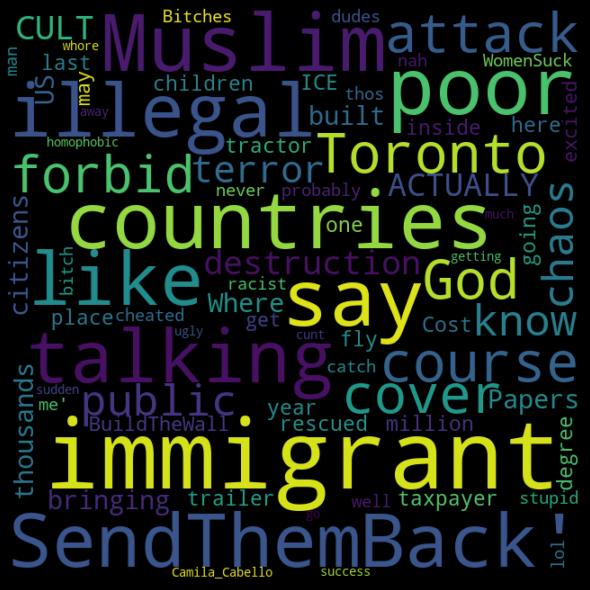

In [ ]:
comments = df['text'].loc[df['HS']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


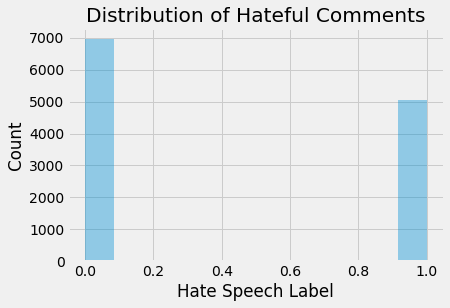

In [ ]:
# Plot frequency of hateful comments
fig = sns.distplot(df['HS'], kde=False)
plt.xlabel("Hate Speech Label")
plt.ylabel("Count")
plt.title("Distribution of Hateful Comments")
plt.show(fig)

In [ ]:
df['HS'].value_counts()


0    6957
1    5043
Name: HS, dtype: int64

TOKENIZATION

In [ ]:
nltk.download('punkt')

nltk_token = df["text_lemmatized"].apply(lambda text:  nltk.word_tokenize(text))
#df.head()
print(nltk_token)
#nltk_tokens = nltk.sent_tokenize(df['text_lemmatized'])
#print (nltk_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0        [definitely, think, kind, 😁, hope, he, massive...
1        [course, toronto, attack, cover, god, forbid, ...
2        [friend, owe, money, theyre, take, little, lon...
3        [maybe, diversityor, result, western, globaliz...
4        [50centfrostyfilms, look, half, dollar, popsic...
                               ...                        
11995    [lmao, guy, remember, someone, hack, twitter, ...
11996    [many, daca, arrest, smuggle, people, borderno...
11997    [dont, get, excite, may, talk, shes, probably,...
11998    [bitch, like, man, never, cheat, lol, nah, bit...
11999    [tho, racisthomophobic, whore, get, much, succ...
Name: text_lemmatized, Length: 12000, dtype: object


In [ ]:
df[["tokenized_text"]] = nltk_token
df.head()

,text,HS,TR,AG,tweet,text_lower,text_wo_punct,text_wo_stop,text_wo_urlno,text_wo_htmlno,text_lemmatized,tokenized_text
0,"Definitely not! I have the same thought, kind ...",0,0,0,"Definitely not! I have the same thought, kind ...","definitely not! i have the same thought, kind ...",definitely not i have the same thought kind of...,definitely thought kind 😁 hope hes massive str...,definitely thought kind 😁 hope hes massive str...,definitely thought kind 😁 hope hes massive str...,definitely think kind 😁 hope he massive stroke...,"[definitely, think, kind, 😁, hope, he, massive..."
1,Of course the Toronto attack is a cover up! Go...,1,0,1,Of course the Toronto attack is a cover up! Go...,of course the toronto attack is a cover up! go...,of course the toronto attack is a cover up god...,course toronto attack cover god forbid public ...,course toronto attack cover god forbid public ...,course toronto attack cover god forbid public ...,course toronto attack cover god forbid public ...,"[course, toronto, attack, cover, god, forbid, ..."
2,When your friend owes you money and they're ta...,0,0,0,When your friend owes you money and they're ta...,when your friend owes you money and they're ta...,when your friend owes you money and theyre tak...,friend owes money theyre taking little long pa...,friend owes money theyre taking little long pa...,friend owes money theyre taking little long pa...,friend owe money theyre take little long pay back,"[friend, owe, money, theyre, take, little, lon..."
3,Maybe diversity.Or results of western globaliz...,0,0,0,Maybe diversity.Or results of western globaliz...,maybe diversity.or results of western globaliz...,maybe diversityor results of western globaliza...,maybe diversityor results western globalizatio...,maybe diversityor results western globalizatio...,maybe diversityor results western globalizatio...,maybe diversityor result western globalization...,"[maybe, diversityor, result, western, globaliz..."
4,#50CentFrostyFilms Look At My Half Dollar PopS...,0,0,0,#50CentFrostyFilms Look At My Half Dollar PopS...,#50centfrostyfilms look at my half dollar pops...,50centfrostyfilms look at my half dollar popsi...,50centfrostyfilms look half dollar popsicle bi...,50centfrostyfilms look half dollar popsicle bi...,50centfrostyfilms look half dollar popsicle bi...,50centfrostyfilms look half dollar popsicle bi...,"[50centfrostyfilms, look, half, dollar, popsic..."


RF


We are converting words to glove embeddings and then finding sentence embeddings.The ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence.
The GloVe embeddings are converted to word2vec format

In [ ]:
#10-fold cross validation for hyperparamter tuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
random_rf_random = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
df_p= df['text_lemmatized']
df_n= df['HS']

In [ ]:
def classify(x):
  if x>0.5:
    return 1
  else:
    return 0

In [ ]:

def rf_model(df_p,df_n):
  class_split=[]
  result=[]
  best_score=[]
  validation=[]
  test=[]


  for i in range(1):
    print(i)

    # split
    x_train, x_test, y_train, y_test = train_test_split(df_p,df_n, test_size=0.20,random_state=3)
    vectorizer = Word2VecVectorizer(model)
      # Get the sentence embeddings for the train dataset
    X_train = vectorizer.fit_transform(x_train)
    # Get the sentence embeddings for the test dataset
    X_test = vectorizer.transform(x_test)

    #number of positives and negatives
    class_split.append({'split_no': i,'train_p':sum(y_train==1),'train_n':sum(y_train==0),'test_p':sum(y_test==1),'test_n':sum(y_test==0)})

    #rf_random search
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_rf_random, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    #probability
    train_prob=rf_random.predict(X_train)
    test_prob=rf_random.predict(X_test)
    #classes
    y_train_pred=[classify(x) for x in train_prob ]
    y_test_pred= [classify(x) for x in test_prob ]# #best score and parameters
  
    best_score.append({'split':i,'score':rf_random.best_score_,'params':rf_random.best_params_})
    # # results of each split
    res = pd.DataFrame(rf_random.cv_results_)
    result.append(res)

    TN,FP,FN,TP = confusion_matrix(y_train,y_train_pred, labels=[0, 1]).ravel()
    # # #Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # # # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # # # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # MCC=matthews_corrcoef(y_train,y_train_pred)
    # # #F1 score
    f1= f1_score(y_train,y_train_pred)
    # # #precision
    train_pr= precision_score(y_train,y_train_pred)
    # # #recall
    train_re = recall_score(y_train,y_train_pred)
    # PR AUC
    # pr_auc_train= average_precision_score(y_train,train_prob)
    # ROC AUC
    # roc_auc_train= roc_auc_score(y_train,train_prob)

    # # #creating dataframe
    validation.append({"Split": i,"Sensitivity":TPR,"Specificity":TNR,"Accuracy":ACC,
                      "Recall":train_re,"Precision":train_pr,"F1_score":f1})
                      #  "PR_AUC":pr_auc_train,"ROC_AUC":roc_auc_train})

    # #storing validation metrics
    tn,fp,fn,tp = confusion_matrix(y_test,y_test_pred,labels=[0, 1]).ravel()
    sensitivity= tp/(tp+fn)
    specificity = tn/(tn+fp)
    acc = (tp+tn)/(tp+fn+fp+tn)
    # mcc= matthews_corrcoef(y_test,y_test_pred)
    #F1 score
    f1_test= f1_score(y_test,y_test_pred)
    #precision
    test_pr= precision_score(y_test,y_test_pred)
    #recall
    test_re = recall_score(y_test,y_test_pred)
    # PR AUC
    # pr_auc_test= average_precision_score(y_test,test_prob)
    # ROC AUC
    # roc_auc_test= roc_auc_score(y_test,test_prob)
    test.append({"Split": i,
                "Sensitivity":sensitivity,"Specificity":specificity,"Accuracy":acc,
                "Recall":test_re,"Precision":test_pr,"F1_score":f1_test})
    # "PR_AUC":pr_auc_test,"ROC_AUC":roc_auc_test})
    
    return test,validation,result,best_score,class_split


In [ ]:
test,validation,result,best_score,class_splits = rf_model(df_p,df_n)

0
Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 46 / 9600
Numer of samples with no words found: 10 / 2400
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
df_t= df.loc[df['HS']==1]

df_t_p= df_t['text_lemmatized']
df_t_n= df_t['TR']

test_t,validation_t,result_t,best_score_t,class_splits_t= rf_model(df_t_p,df_t_n)


0
Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 9 / 4034
Numer of samples with no words found: 4 / 1009
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
df_a_n=df_t['AG']
test_a,validation_a,result_a,best_score_a,class_splits_a = rf_model(df_t_p,df_a_n)

0
Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 9 / 4034
Numer of samples with no words found: 4 / 1009
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
valid_df= pd.DataFrame(validation)
test_df=pd.DataFrame(test)
splits= pd.DataFrame(class_splits)
score= pd.DataFrame(best_score)

In [ ]:
splits

,split_no,train_p,train_n,test_p,test_n
0,0,4035,5565,1008,1392


In [ ]:
score['params'].to_list()

[{'bootstrap': False,
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 80}]

In [ ]:
test_df

,Split,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,0.458333,0.817529,0.666667,0.458333,0.645251,0.535963


In [ ]:
valid_df

,Split,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,0.980917,0.997305,0.990417,0.980917,0.996225,0.988511


In [ ]:
targeted_test_df=pd.DataFrame(test_t)
targeted_valid_df=pd.DataFrame(validation_t)
targeted_splits= pd.DataFrame(class_splits_t)
targeted_score=pd.DataFrame(best_score_t)

In [ ]:
targeted_test_df

,Split,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,0.734072,0.87037,0.821606,0.734072,0.759312,0.746479


In [ ]:
targeted_valid_df

,Split,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,0.987409,0.998812,0.994546,0.987409,0.997991,0.992672


In [ ]:
targeted_splits

,split_no,train_p,train_n,test_p,test_n
0,0,1509,2525,361,648


In [ ]:
targeted_score['params'].to_list()

[{'bootstrap': False,
  'max_depth': 60,
  'max_features': 'sqrt',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 70}]

In [ ]:
agressive_test_df=pd.DataFrame(test_a)
agressive_valid_df=pd.DataFrame(validation_a)
agressive_splits= pd.DataFrame(class_splits_a)
agressive_score=pd.DataFrame(best_score_a)

In [ ]:
agressive_test_df

,Split,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,0.457346,0.773424,0.641229,0.457346,0.592025,0.516043


In [ ]:
agressive_valid_df

,Split,Sensitivity,Specificity,Accuracy,Recall,Precision,F1_score
0,0,0.96476,0.983934,0.975706,0.96476,0.978325,0.971495


In [ ]:
agressive_splits

,split_no,train_p,train_n,test_p,test_n
0,0,1731,2303,422,587


In [ ]:
agressive_score['params'].to_list()

[{'bootstrap': False,
  'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 100}]

In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 5.5 MB/s 


In [ ]:
writer = pd.ExcelWriter('GloVe_NLP_randomforest_aggressive.xlsx', engine='xlsxwriter')
for i,data in enumerate(result):
    data.to_excel(writer, sheet_name= 'Split_{}'.format(i),index=False)
writer.save()

In [ ]:
writer = pd.ExcelWriter('GloVe_NLP_randomforest_targeted.xlsx', engine='xlsxwriter')
for i,data in enumerate(result):
    data.to_excel(writer, sheet_name= 'Split_{}'.format(i),index=False)
writer.save()

In [ ]:
writer = pd.ExcelWriter('GloVe_NLP_randomforest.xlsx', engine='xlsxwriter')
for i,data in enumerate(result):
    data.to_excel(writer, sheet_name= 'Split_{}'.format(i),index=False)
writer.save()

In [ ]:
valid_df.to_excel('glove_rf_validation.xlsx',index=False)
test_df.to_excel('glove_rf_test.xlsx',index=False)

In [ ]:
targeted_valid_df.to_excel('glove_rf_validation_target.xlsx',index=False)
targeted_test_df.to_excel('glove_rf_test_target.xlsx',index=False)

In [ ]:
agressive_valid_df.to_excel('glove_rf_validation_agressive.xlsx',index=False)
agressive_test_df.to_excel('glove_rf_test_agressive.xlsx',index=False)

In [ ]:
from google.colab import files
files.download('glove_rf_validation.xlsx')